# Isolating phyllotactic features from cherry tree
## Notebook 2: Visualization

In [1]:
# Standard python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
import pandas as pd
import scipy.misc
import csv
from scipy import ndimage as ndi

# Cherry tools
from radius import find_radii
from pith import find_center
from polar import save_polar_all
from helix_interpolation import get_helix

# Skimage
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops

# Scan constants
global THICKNESS 
global SPACING
THICKNESS = 0.625000
SPACING = 0.351562

# The golden angle
global GOLD1
GOLD1 = 2.39996322972865332

In [2]:
# Helper functions
def inside_circle(p):
	s = 255
	return (p[0] - s)**2 + (p[1] - s)**2 < s**2

# Get raw cherry image
def get_image(img_id):
	return np.load("../data/cherry_stump/processed/cherry"+str(img_id).zfill(4)+".npy")

# Helper function to load polar images
def get_polar(img_id):
	return np.load("./out/polar/rad_polar"+str(img_id).zfill(4)+'.npy') 

# Euclidean distance
def dist(p1,p2):
	return np.power(np.power(p1[0]-p2[0],2) + np.power(p1[1]-p2[1],2), 0.5)

def toDegrees(R):
	return R*(360/(2*np.pi))


In [3]:
# Create data frame for center
center_table = pd.read_csv("./out/center_coords.csv", index_col=0)

# Create dataframe for radius
radius_table = pd.read_csv("./out/radius.csv",index_col=0)
radius_table['r_adjusted'] = radius_table['r'] * SPACING 

# Compute radius
global RADIUS
RADIUS = float(radius_table['r_adjusted'].median())
print("Median radius is",RADIUS,"cm")

Median radius is 47.17354233456737 cm


---
## Paristichies

In [4]:
## Helper functions to plot paristichies

# Plot paristichy lines on axis ax, point set S, circumference C and hanedness hand
def plot_par_lines(ax,jump,S,C,hand,color='black'):
	for start in range(jump):
		for i in range(start,N-jump,jump):
			theta1,z1 = S[i,:]
			theta2,z2 = S[i+jump,:]

			slope = (theta2 - theta1) / (z2 - z1)

			cond = (theta1 < theta2)
			if hand == -1:
				cond = (theta1 > theta2)
                
            # Regular plotting line
			if cond:
				ax.plot([z1,z2],[theta1,theta2],color)
                
            # Plot over cut    
			else:
				theta1 = S[i,0]-hand*C
				ax.plot([z1,z2],[S[i,0]-hand*C,theta2],color)
				theta1 = S[i,0]
				theta2 = S[i+jump,0]+hand*C
				ax.plot([z1,z2],[theta1,theta2],color)

# Plot text 
def plot_circle_text(x,y,text,ax,clip=True,color="black"):
	bbox_props = dict(boxstyle="circle", fc=color,ec=color)
	ax.text(x,y, text, ha="center", color="white",va="center", rotation=0,size=8, bbox=bbox_props,clip_on=clip)

# Plot at point (x,y) with circumference C and threshold T
def plot_circle(x,y,C,T=40,color='black'):
	if x - C < T and x - C > 0:
		plot_circle_text(y,x,str(i),ax,False,color)
		plot_circle_text(y,x+C,str(i),ax,False,color)
		#plot_circle_text(y,x-C,str(i),ax,False)
	elif C - x < T and C - x > 0:
		plot_circle_text(y,x,str(i),ax,False,color)
		plot_circle_text(y,x-C,str(i),ax,True,color)
	else:
		plot_circle_text(y,x,str(i),ax,True,color)
	

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

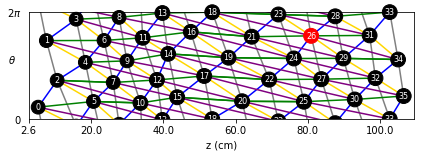

In [15]:
# Bounds calculation
I = [10,1852] # Slice range corresponding to tree
h = I[1] - I[0] # height of tree in slices
a = h - (1810-I[0]) # Starting slice
b = h - (100-I[0]) # Ending slice

get_xmin = a * THICKNESS / 10
get_xmax = b * THICKNESS / 10

# Constants
T = 40 # Threshold for double plot

# Get coordinates
S = np.loadtxt("./out/raw_meristem_coords.csv",delimiter=",")
N = S.shape[0]
S = S[np.argsort(S[:, 1])]

# Flip UD to align with boundary iage
S[:,0] = 2*np.pi*RADIUS - S[:,0]

# Adjust units to mm
S[:,0] = S[:,0] / 10
S[:,1] = S[:,1] / 10
r = RADIUS / 10
C = 2*np.pi*r # Circumference

# Pair to examine
jumps = [1,2,3,5,8]
handedness = {3:-1, 1:-1, 8:-1, 2:1, 5:0}
colors =  {1:"gray", 2: "blue", 3: "gold", 5: 'green', 8: "purple"}
circle_color = {i:'black' for i in range(N)}
circle_color[26] = "red"

# Create plot
plt.clf()
fig, ax = plt.subplots()#figsize=(0.8*8,0.8*3)

# Plot paristichy lines
for jump in jumps:
	plot_par_lines(ax,jump,S,C,handedness[jump],colors[jump])

# Plot circles at nodes
for i in range(N):
	plot_circle(S[i,0],S[i,1],C,T,circle_color[i])

# Plot labels
y = ax.set_ylabel(r'$\theta$',labelpad=-5)
x = ax.set_xlabel("z (cm)")
y.set_rotation(0)

# Change ticks and limits
ax.set_ylim([0,C])
ax.set_yticks([0,C])
ax.set_yticklabels(["$0$", "$2\pi$"])#\n(32.2cm)
ax.set_xticks(list(np.arange(20., get_xmax+1, 20))+[round(get_xmin,1)])#+[get_xmax]
ax.tick_params(axis='y',left=False)
ax.set_xlim([get_xmin, get_xmax])

patches_list = []
for jump in jumps:
    p = patches.Patch(color=colors[jump], label=str(jump)+'-family')
    patches_list.append(p)
#plt.figlegend(handles=patches_list,loc = 'lower center', ncol=2, labelspacing=0.,bbox_to_anchor=(0.5,-0.1) )

# Plot
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig("./out/AllParistichies.png",dpi=300)
plt.show()

## Divergence angle and rise

Mean Divergence (rad) = 0.0945991069475566
Mean Divergence (deg) = 5.420129573801697
Min Angle (deg) = 152.02030693350923
Max Angle (deg) = 115.34759360392049
**Mean Angle (deg) = 142.92789362383957 (+/-) 1.180725416928912
**Mean Angle (rad) = 2.49456233667621 (+/-) 0.02060754608739231
**Mean Fraction = 0.3970219267328877 (+/-) 0.0032797928248025333
Median Angle (deg) = 142.6109165379108
Mean Rise (mm) = 28.963001825416267
Rise error (mm) =  1.817463391659588


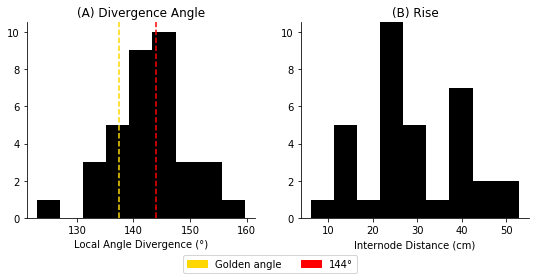

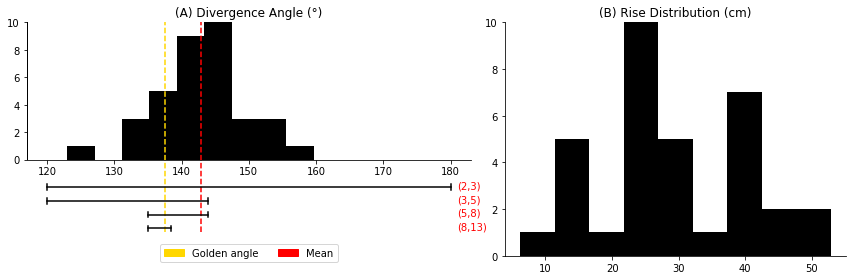

In [6]:
# Report angle distribution for our data
plt.close("all")

# Load data
spiral_points = np.loadtxt("./out/meristem_coords.csv",delimiter=",")
N = spiral_points.shape[0]

# Adjust points
r = RADIUS
spiral_points = spiral_points[np.argsort(spiral_points[:, 1])]
spiral_points[:,0] = spiral_points[:,0] / r


# Collect angle divergence and plastichrone ratios
angs, rise = [], []
raw_angs = []
fractions = []
for i in range(N-1):
	ang = (spiral_points[i+1,0] - spiral_points[i,0]) % (2 * np.pi)
	fractions.append(ang/(2*np.pi))

	raw_angs.append(toDegrees(ang))
	ang = ang - GOLD1
	angs.append(ang)
	rise.append(spiral_points[i+1,1] - spiral_points[i,1])

mean = sum(angs)/len(angs)

# Compute error
mean_error = np.array(raw_angs).std() / np.sqrt(len(raw_angs)-1)
mean_error_rad = (np.array(angs)+GOLD1).std() / np.sqrt(len(angs)-1)
frac_error = np.array(fractions).std() / np.sqrt(len(fractions)-1)

# Report sizes of things
print("Mean Divergence (rad) =", mean)
print("Mean Divergence (deg) =",toDegrees(mean))
print("Min Angle (deg) =",toDegrees(-min(angs)+GOLD1))
print("Max Angle (deg) =",toDegrees(-max(angs)+GOLD1))
print("**Mean Angle (deg) =",np.array(raw_angs).mean(), "(+/-)", mean_error)
print("**Mean Angle (rad) =",mean+GOLD1, "(+/-)", mean_error_rad)
print("**Mean Fraction =",np.array(fractions).mean(), "(+/-)", frac_error)
print("Median Angle (deg) =",toDegrees(np.median(angs)+GOLD1))
print("Mean Rise (mm) =",sum(rise)/len(rise))
print("Rise error (mm) = ",np.std(rise)/np.sqrt(len(rise)-1))

## First plot ##
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].axvline(144,color="red",linestyle="dashed")
ax[0].axvline(toDegrees(GOLD1),color="gold",linestyle="dashed")
ax[0].hist(raw_angs,color="black",bins=9)#"o-",
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("(A) Divergence Angle")
ax[0].set_xlabel("Local Angle Divergence (°)")
ax[0].spines['bottom'].set_position('zero')

#ax[1].axhline(avg_rise,color="red",linestyle="dashed")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].hist(rise,color="black",bins=9)#"o-",
ax[1].set_title("(B) Rise")
ax[1].set_xlabel("Internode Distance (cm)")
ax[1].set_ylim(ax[0].get_ylim())

patch1 = patches.Patch(color='gold', label='Golden angle')
patch2 = patches.Patch(color='red', label='144°')
patches_list = [patch1,patch2]
leg = fig.legend(handles=patches_list,ncol=2,loc=8)#bbox_to_anchor=(0.5, -0.2),)#fontsize='small'
#ax.axis('off')

fig.subplots_adjust(bottom=0.2)
#plt.tight_layout()
plt.show()
#plt.savefig("./out/params.png",dpi=300)


## Second plot ##
fig, ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw = {'width_ratios':[1.3, 1]})

ax[0].axvline(toDegrees(GOLD1),color="gold",linestyle="dashed",ymin=0.1)
ax[0].axvline(toDegrees(mean+GOLD1),color="red",linestyle="dashed",ymin=0.1)
ax[0].hist(raw_angs,color="black",bins=9)#"o-",
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title("(A) Divergence Angle (°)")
#ax[0].set_xlabel("Local Angle Divergence ", labelpad=65)
ax[0].set_ylim(-7,10)
epsilon = 0.2


X1 = [(1/3)*360,(1/2)*360]
Y1 = [-2]*len(X1)
ax[0].plot(X1,Y1,"-",color="black")
for x in X1:
    Y = [-2-epsilon,-2+epsilon]
    X = [x]*len(Y)
    ax[0].plot(X,Y,"-",color="black")

    
X2 = [(1/3)*360,(2/5)*360]
Y2 = [-3]*len(X2)
ax[0].plot(X2,Y2,"-",color="black")
for x in X2:
    Y = [-3-epsilon,-3+epsilon]
    X = [x]*len(Y)
    ax[0].plot(X,Y,"-",color="black")

    
X3 = [(3/8)*360,(2/5)*360]
Y3 = [-4]*len(X3)
ax[0].plot(X3,Y3,"-",color="black")
for x in X3:
    Y = [-4-epsilon,-4+epsilon]
    X = [x]*len(Y)
    ax[0].plot(X,Y,"-",color="black")

        
X4 = [(5/13)*360,(3/8)*360]
Y4 = [-5]*len(X3)
ax[0].plot(X4,Y4,"-",color="black")
for x in X4:
    Y = [-5-epsilon,-5+epsilon]
    X = [x]*len(Y)
    ax[0].plot(X,Y,"-",color="black")
    
ax[0].spines['bottom'].set_position('zero')
ax[0].annotate("(2,3)",(181,-2.1),color="red")
ax[0].annotate("(3,5)",(181,-3.1),color="red")
ax[0].annotate("(5,8)",(181,-4.1),color="red")
ax[0].annotate("(8,13)",(181,-5.1),color="red")
ax[0].set_yticks([0,2,4,6,8,10])
ax[0].spines['left'].set_visible(False)
small_y = ax[0].get_xlim()[0]
ax[0].axvline(small_y,ymin=0.415,color="black",linewidth=1)

#ax[1].axhline(avg_rise,color="red",linestyle="dashed")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].hist(rise,color="black",bins=9)#"o-",
ax[1].set_title("(B) Rise Distribution (cm)")
#ax[1].set_xlabel("Internode Distance ")
ax[1].set_ylim(0,ax[0].get_ylim()[1])

patch1 = patches.Patch(color='gold', label='Golden angle')
patch2 = patches.Patch(color='red', label='Mean')
patches_list = [patch1,patch2]
leg = ax[0].legend(handles=patches_list,ncol=2,loc=8,bbox_to_anchor=(0.5, -0.05))#,)#fontsize='small'

plt.tight_layout(h_pad=100)
plt.savefig("./out/Parameters.png",dpi=300)
plt.show()



---
## Figure: Slices

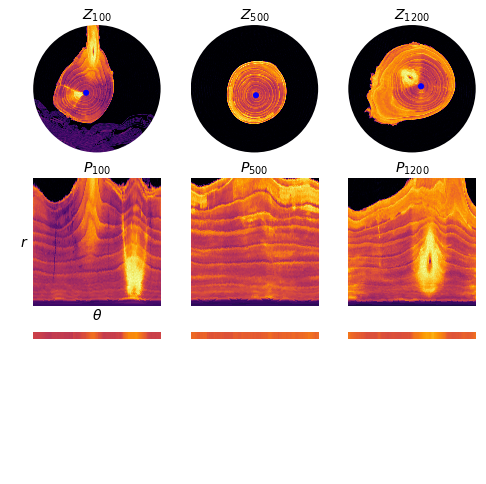

In [7]:
# Get center of image
def get_center(img_id):
	my_row = center_table.loc[img_id]
	return int(my_row["x"]), int(my_row["y"])

# Slices to plot
idx_range = [100,500,1200]#range(100,301,100)

# Load data
all_points = np.load("./out/heat_map_mean.npy")
voxel = np.load("../data/cherry_stump/processed/cherry.npy")

# Create plot
fig, ax = plt.subplots(3,len(idx_range),figsize=(8, 8),sharey=True)

# Plot each slice
i = 0
for idx in idx_range:
	A = np.array([all_points[:,np.shape(all_points)[1]-(idx-100)-1],]*30)

	# Polar
	polar_slice = get_polar(idx)
	zslice = voxel[:,:,idx]
	vmax = np.max(zslice)
	ax[1,i].imshow(np.flipud(polar_slice),vmin=-1000,vmax=vmax,cmap="inferno")
	
	# Mean bar
	ax[2,i].imshow(A,cmap='inferno',vmin=-1000,vmax=vmax)

	# Orginal scan
	im = ax[0,i].imshow(zslice,vmin=-1000,cmap="inferno")
	patch = patches.Circle((255,255), radius=255, transform=ax[0,i].transData)
	im.set_clip_path(patch)
    
	for k in range(3):
		ax[k,i].axis("off")

	ax[0,i].add_artist(plt.Circle(get_center(idx), 10, color='blue'))
	i = i + 1

# Text labels for Z
i = 0
for idx in idx_range:
	textstr="$Z_{"+str(idx)+"}$"
	ax[0,i].text(0.5, 1.05, textstr, 
                 fontsize=14,
                 transform=ax[0,i].transAxes,
                 horizontalalignment='center')
	i += 1

# Text labels for P
i = 0
for idx in idx_range:
	textstr="$P_{"+str(idx)+"}$"
	ax[1,i].text(0.5, 1.05, textstr,
                 fontsize=14,
                 transform=ax[1,i].transAxes,
                 horizontalalignment='center')
	i += 1

# Text labels for vectors
#i = 0
#for idx in idx_range:
#	textstr="$b_{"+str(idx)+"}$"
#	ax[2,i].text(0.5, 1.05, textstr,fontsize=14,transform=ax[2,i].transAxes,horizontalalignment='center')
#	i += 1

# r and theta labels
ax[1,0].text(-0.07, 0.5, "$r$",fontsize=14,transform=ax[1,0].transAxes,verticalalignment='center',horizontalalignment='center')
ax[1,0].text(0.5, -.07, r'$\theta$',fontsize=14,transform=ax[1,0].transAxes,verticalalignment='center',horizontalalignment='center')

#fig.subplots_adjust(top=10)
#plt.tight_layout()#pad=1
#plt.savefig("./out/slice_drainage.png",dpi=300)
plt.show()

---
## Phyllotaxy examples

In [8]:
# Generate sample node data
def generate_lattice(phi = 2.3999632297, N = 1000, p = 1, spiral=False):
	theta = [(phi*n) % (2*np.pi) for n in range(N)]
	z = [pow(n,p) for n in range(N)]
	L = np.array([theta,z]).T
    
	if spiral:
		return np.column_stack([L[:,1] * np.cos(L[:,0]), L[:,1] * np.sin(L[:,0])])

	return L

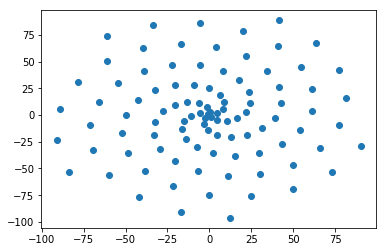

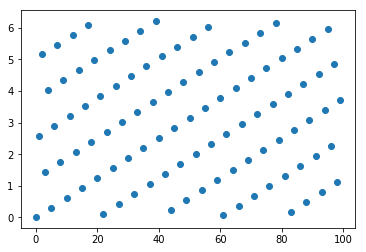

In [9]:
# Example data
L = generate_lattice(phi=(0.41)*2*np.pi,N = 100,p=1)

# Plot spiral
x = L[:,1] * np.cos(L[:,0])
y = L[:,1] * np.sin(L[:,0])
plt.scatter(x,y)
plt.show()

# Plot cylindrical lattice
plt.scatter(L[:,1],L[:,0])
plt.show()

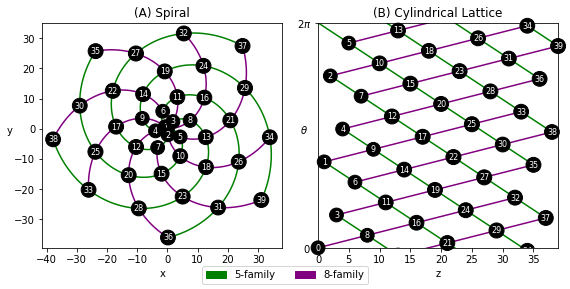

In [10]:
# Constants
N = 40 
C = 2*np.pi # Circumference
T = 40 # Threshold for double plot
S = generate_lattice(N = N,p=1)
P = generate_lattice(N = N,p=1,spiral=True)
#S = generate_lattice(phi=0.403*2*np.pi,N = N,p=1.07)
#P = generate_lattice(phi=0.403*2*np.pi,N = N,p=1.07,spiral=True)
#S[:,0] = 2*np.pi - S[:,0]
#P[:,0] = 2*np.pi - P[:,0]

jumps = [5,8]#[5,8]
handedness = {1:1, 2:-1, 3:1, 5:-1, 8:1, 13:-1}
color =  {1:"gray", 2: "blue", 3: "gold", 5: 'green', 8: "purple"}
circle_color = {i:'black' for i in range(N)}

########
plt.figure(figsize=(8,4))

ax = plt.subplot(121)
ax1 = ax
plt.title("(A) Spiral")

y = ax.set_ylabel("y")
x = ax.set_xlabel("x")
y.set_rotation(0)

ax.scatter(P[:,0],P[:,1],color="black")
for i in range(N):
	text = str(i)
	bbox_props = dict(boxstyle="circle", fc="black",ec="black")
	ax.text(P[i,0],P[i,1], text, ha="center", color="white",va="center", rotation=0,size=8, bbox=bbox_props)

# Plot segments
for jump in jumps:
	omegas = []
	hand = handedness[jump]

	for start in range(jump):
		for i in range(start,N-jump,jump):
			theta0,z0 = S[i,:]
			theta1,z1 = S[i+jump,:]
			(omega, phi) = get_helix(theta0, z0, theta1, z1, hand)

			z = np.linspace(z0, z1, 100)
			x = np.cos(omega * z + phi)*z
			y = np.sin(omega * z + phi)*z
			ax.plot(x, y,color[jump])

			omegas.append(omega)
patches_list = []
for jump in jumps:
    p = patches.Patch(color=color[jump], label=str(jump)+'-family')
    patches_list.append(p)

#leg = ax.legend(handles=patches_list)
ax.set_aspect('equal')

ax = plt.subplot(122)
plt.title("(B) Cylindrical Lattice")

# Create plot
ax.set_ylim([0,C])
ax.set_xlim((0, np.max(S[:,1])))  

# Plot lines
for jump in jumps:
	plot_par_lines(ax,jump,S,C,handedness[jump],color[jump])

# Plot circles
for i in range(N):
	plot_circle(S[i,0],S[i,1],C,T,circle_color[i])

# Labels
y = ax.set_ylabel(r'$\theta$',labelpad=-7)
x = ax.set_xlabel("z")
y.set_rotation(0)
ax.set_yticks([0,C])
ax.set_yticklabels(["$0$", "$2\pi$"])

# Set aspect ratio
asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
ax.set_aspect(asp)

#ax.set_aspect("auto")
plt.figlegend(handles=patches_list,loc = 'lower center', ncol=2, labelspacing=0.)#,bbox_to_anchor=(0.4,0.03) )

plt.tight_layout()
plt.savefig("./out/ParistichyExample.png",dpi=300)
plt.show()

---
## Radius algorithm 

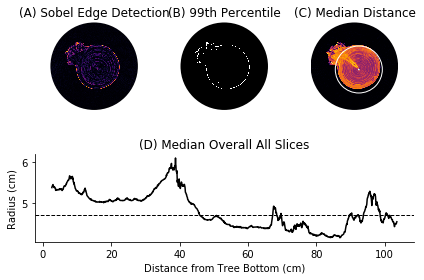

In [11]:
def get_center(img_id):
	my_row = center_table.loc[img_id]
	return int(my_row["x"]), int(my_row["y"])

img_id = 700#321
cmap = plt.cm.inferno
img = get_image(img_id)
vmax = np.max(img)
circle_mask = np.fromfunction(lambda i, j: inside_circle((i,j)), img.shape,dtype='int')

edges = sobel(img,  mask=circle_mask )
N = 3
indices = np.argpartition(edges , -N, axis=1)[:, -N:]
#print(indices)

center = get_center(img_id)
mod_edges = edges > np.percentile(edges,99)
boundary_locations = np.array(np.nonzero(mod_edges)).T

distances = []
for i,j in boundary_locations:
	distances.append(dist((i,j),(center[1], center[0])))

radius = np.median(distances)

# Circles for center and radius
circle1 = plt.Circle(center, radius , fill=False,color='white')
circle2 = plt.Circle(center, 2 ,color='white')

# Create plot
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1),sharex=ax1,sharey=ax1)
ax3 = plt.subplot2grid((2, 3), (0, 2),sharex=ax1,sharey=ax1)
ax4 = plt.subplot2grid((2, 3), (1, 0),colspan=3)
fig = plt.gcf() 

# (A) panel
im = ax1.imshow(edges, cmap=cmap )
patch = patches.Circle((255,255), radius=255, transform=ax1.transData)
im.set_clip_path(patch)
ax1.set_title('(A) Sobel Edge Detection')

# (B) panel
im = ax2.imshow(mod_edges, cmap="gray")
ax2.set_title('(B) 99th Percentile')
patch = patches.Circle((255,255), radius=255, transform=ax2.transData)
im.set_clip_path(patch)

# (C) panel
ax3.add_artist(circle1)
ax3.add_artist(circle2)
im = ax3.imshow(img, cmap=cmap,vmin=-1000)
ax3.set_title('(C) Median Distance')
patch = patches.Circle((255,255), radius=255, transform=ax3.transData)
im.set_clip_path(patch)

# Adjust plot
fig.subplots_adjust(wspace=-0.5)
SPACING = 0.351562
R = np.loadtxt("./out/radius.csv",delimiter=",",skiprows=1)
plt.title("(D) Median Overall All Slices")
plt.ylabel("Radius (cm)")

z = R[:,0]
rads = R[:,1]*SPACING/10

top = z[-1]
for i in range(R.shape[0]):
	z[i] = (top - z[i])/top

for i in range(R.shape[0]):
	z[i] = z[i]*(109.5-2.625) + 2.625

med = np.median(rads)
ax4.plot(z,rads,color="black")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.axhline(med,color="black",linewidth=1,linestyle="--")
x = ax4.set_xlabel("Distance from Tree Bottom (cm)")

# Plot
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.tight_layout()
plt.savefig("./out/Radius.png")
plt.show()



---
## Paristichies in 3D

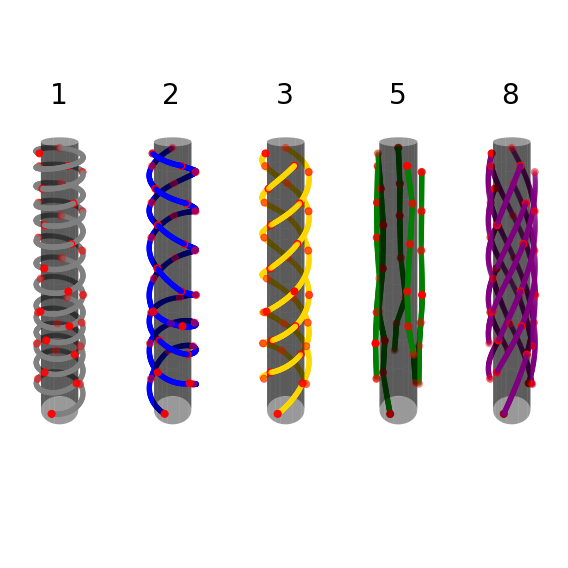

In [12]:
# Parameters
point_colors =  {1:"gray", 2: "blue", 3: "gold", 5: 'green', 8: "purple"}
handedness = {1:1,2:-1,3:1,5:0,8:1}
skips = [1,2,3,5,8]
num_plots = len(skips)

# Plot helix
def plot_spiral(ax, points, color, hand,azim):
	for i in range(len(points)-1):
		z1, z2 = points[i,1], points[i+1,1]
		theta1, theta2 = points[i,0], points[i+1,0]
		omega, phi = get_helix(theta1, z1, theta2, z2,hand)
		z = np.linspace(z1, z2, 50)
		x = np.cos(omega * z + phi)
		y = np.sin(omega * z + phi)
		ax.scatter(x, y, z, color=color)

#https://stackoverflow.com/questions/41699494/how-to-obscure-a-line-behind-a-surface-plot-in-matplotlib
	# Plot points
	ax.scatter(np.cos(points[:,0]), np.sin(points[:,0]), points[:,1], color="red",depthshade=True,s=50)

	# View
	ax.view_init(elev=5, azim=azim)

def plot_cylinder(ax, zmax):
	# Cylinder
	R = .8
	x=np.linspace(-R, R, 100)
	z=np.linspace(0, zmax, 100)
	Xc, Zc=np.meshgrid(x, z)
	Yc = np.sqrt(R**2-Xc**2)

	# https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
	# Draw parameters
	rstride = 10
	cstride = 10
	alpha = 0.4
	color = 'black'
	ax.plot_surface(Xc, Yc, Zc, alpha=alpha , rstride=rstride, cstride=cstride, color=color,shade=True)
	ax.plot_surface(Xc, -Yc, Zc, alpha=alpha , rstride=rstride, cstride=cstride, color=color)

# Load data
S = np.loadtxt("./out/raw_meristem_coords.csv",delimiter=",")
N = S.shape[0]
S = S[np.argsort(S[:, 1])]
S[:,0] /= RADIUS
zmax = 1100

azim = 18

## Setup figure ##
fig = plt.figure(figsize=2*plt.figaspect(1))

# Plot paristichies
k = 1
for s in skips:
	ax = fig.add_subplot(1, num_plots, k, projection='3d')
	plot_cylinder(ax, zmax)

	for i in range(s):
		plot_spiral(ax, S[i::s,:], point_colors[s], handedness[s],img_id)
	
	ax.axis('off')
	ax.set_title(str(s),pad=-50,fontsize=28)#+"-family"
	k += 1
plt.tight_layout()

plt.savefig("./out/Helices.png",dpi=300, transparent=False,bbox_inches='tight')
plt.show()


---
## Boundary image 

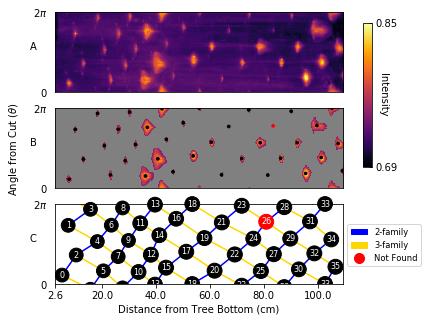

In [30]:
## Plot boundary image ##

# Determine colorbar range
V = np.load("../data/cherry_stump/processed/cherry.npy")
org_img = np.load("./out/heat_map_mean.npy")
colorbar = matplotlib.colors.Normalize(vmin=np.min(V),vmax=np.max(V))
hmin = np.min(org_img)
hmax = np.max(org_img)
MIN, MAX = colorbar(hmin),colorbar(hmax)

# Parameters and constants
r = RADIUS / 10
C = 2*np.pi*r

# Bounds calculation
I = [10,1852] # Slice range corresponding to tree
h = I[1] - I[0] # height of tree in slices
a = h - (1810-I[0]) # Starting slice
b = h - (100-I[0]) # Ending slice

get_xmin = a * THICKNESS / 10
get_xmax = b * THICKNESS / 10

# Help to make the first two plots
def make_surface_plot(ax,all_points, cmap='inferno',colorbar=True):
	im = ax.imshow(all_points,
		cmap=cmap,
		extent=[get_xmin, get_xmax, 0, C],
		aspect=(all_points.shape[1]/all_points.shape[0])*(C /(get_xmax-get_xmin)),
		vmin=hmin, vmax=hmax
	)

	ax.set_xlim([get_xmin, get_xmax])
	ax.tick_params(axis='y',left=False)
	ax.tick_params(axis='x',bottom=False)

	if colorbar:
		cbar = fig.colorbar(im,ticks=[np.min(all_points),np.max(all_points)])
		cbar.ax.set_yticklabels([np.round(MIN,2),np.round(MAX,2)])  

	return im

# Create figure
fig = plt.figure(figsize=(6.5,5))

##########
# PLOT 1 #
##########

# Plot heatmap
ax1 = fig.add_subplot(311)
#ax1.margins(1)
im = make_surface_plot(ax1,org_img,colorbar=False)

##########
# PLOT 2 #
##########

ax2 = fig.add_subplot(312,sharex=ax1,sharey=ax1)

# Make 3 stacked copies of image
image = np.vstack([org_img]*3)

# Threshold
binary_global = image > threshold_otsu(image)
image = binary_global

# Remove small objects
image = remove_small_objects(image,min_size=100)#remove_small_objects(image,min_size=150)

# Put back in image
s = image.shape[0]
third = image[s//3:s-(s//3),:] # Grab middle third
img = np.copy(org_img) # Copy orginal
img[~third] = np.nan # Mask with threshold

# Label
image,num_labels = ndi.label(image)

# Find index centers
props = regionprops(image)
mean = np.array([props[i].centroid for i in range(len(props))]).T

# Add missing one
org_shape = org_img.shape
a,b = (114.61904761904762, 1295.095238095238)

mean = np.hstack([mean,[[a + org_shape[0]], [b]]])
adjusted_means = []

# Keep only means in the middle third
for i in range(1,mean.shape[1]):
	if (org_shape[0] <= mean[0,i]) and (mean[0,i] < 2*org_shape[0]):
		m0 = ((mean[1,i] / org_shape[1])*(1810-100)*THICKNESS/10) + get_xmin
		m1 = 2*np.pi*r - ((mean[0,i] % org_shape[0])/org_shape[0])*(2*np.pi*r)
		adjusted_means.append((m0, m1))

# Plot
masked_array = np.ma.array(img, mask=np.isnan(img))
cmap = cm.inferno
cmap.set_bad('gray',1.) # Background colro

make_surface_plot(ax2,masked_array,colorbar=False)

# Add dots to plot
last_mean = adjusted_means.pop()

for m in adjusted_means:
	ax2.add_artist(plt.Circle(m, 0.5, color='black'))
ax2.add_artist(plt.Circle(last_mean, 0.5, color='red'))

##########
# PLOT 3 #
##########

S = np.loadtxt("./out/raw_meristem_coords.csv",delimiter=",")
N = S.shape[0]
S = S[np.argsort(S[:, 1])]

S[:,0] = 2*np.pi*RADIUS - S[:,0]
S[:,0] = S[:,0] / 10
S[:,1] = S[:,1] / 10
r = RADIUS / 10
C = 2*np.pi*r

ax3 = fig.add_subplot(313,sharex=ax1,sharey=ax1)

ax = ax3
jumps = (2,3)
colors =  {1:"gray", 2: "blue", 3: "gold", 5: 'green', 8: "purple"}
handedness = {1:1,2:-1,3:1,5:0,8:1}
for jump in jumps:
	plot_par_lines(ax,jump,S,C,-1*handedness[jump],color=colors[jump])
                

for i in range(N):    
	if i == 26:
		color = "red"
	else:
		color = "black"

	plot_circle(S[i,0],S[i,1],C,5,color)
    
###########
# Options #
###########

# Set limits and ticks
ax.set_xlim([get_xmin, get_xmax])
x = ax.set_xlabel("Distance from Tree Bottom (cm)")
ax.set_ylim([0,C])
ax.set_yticks([0,C])
ax.set_yticklabels(["$0$", "$2\pi$"])
ax.set_xticks(list(np.arange(20., get_xmax+1, 20))+[round(get_xmin,1)])#+[get_xmax]
ax.tick_params(axis='y',left=False)
ax.use_sticky_edges = True

# Create patches for legend 
red_patch = patches.Patch(color='blue', label='2-family')
green_patch = patches.Patch(color='gold', label='3-family')

blue = plt.plot([],[], marker="o", ms=10, ls="", mec=None, color="red", 
            label="{:s}".format("Not Found") )[0] 

# Legend
leg = ax.legend(handles=[red_patch,green_patch,blue],bbox_to_anchor=(1.0,0.8),fontsize='small')# loc='center left')#,bbox_to_anchor=(1, 0.5), loc='upper center',)#prop=fontP)#loc=5)

# Colorbar
fig.subplots_adjust(right=0.8,left=0.1)
cbar_ax = fig.add_axes([0.8, 0.45, 0.02, 0.4])
cb = fig.colorbar(im, cax=cbar_ax,ticks=[np.min(org_img),np.max(org_img)])

cb.ax.set_yticklabels([np.round(MIN,2),np.round(MAX,2)])  
cb.ax.tick_params(axis='y',direction='in',labeltop='on')
cb.ax.set_ylabel('Intensity', rotation=270,labelpad=-10)

# Adjust axes and add panel labels
axes = [ax1,ax2,ax3]
panel_labels = ["A", "B", "C"]
i = 0
for a in axes:
    a.label_outer()
    a.set_aspect('equal')
    y = a.set_ylabel(panel_labels[i],labelpad=0)
    y.set_rotation(0)
    i += 1

fig.text(0.04, 0.5, r'Angle from Cut ($\theta$)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.2,wspace=2)
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('./out/PhyllotacticFeatures.png', bbox_inches='tight',dpi=300)
plt.show()

